# Reinforcement Learning 2025 - Midterm Assignment

**Environment:** MiniGrid-Dynamic-Obstacles-6x6-v0  
**Authors:** [Your Name], [Partner's Name]  
**Goal:** Implement and compare SARSA and Double Q-Learning agents in a dynamic obstacle environment.  

In [32]:
import numpy as np
import gymnasium as gym
import minigrid
import matplotlib.pyplot as plt
from collections import defaultdict
import pickle

np.random.seed(42)

In [33]:
def get_state(obs):
    """Convert observation to a hashable state key."""
    return (obs["direction"], tuple(obs["image"].flatten()))


def init_q_table(env):
    """Initialize a Q-table with small random values for each possible action."""
    return defaultdict(lambda: np.random.uniform(0, 0.01, env.action_space.n))


def epsilon_greedy_action(state, q_lookup, epsilon, action_space):
    """Select an action using an epsilon-greedy policy."""
    if np.random.rand() < epsilon:
        return action_space.sample()
    return int(np.argmax(q_lookup[state] if callable(q_lookup) is False else q_lookup(state)))


def log_episode(logs, reward, steps, success):
    """Store training statistics for later analysis."""
    logs["rewards"].append(reward)
    logs["steps"].append(steps)
    logs["successes"].append(int(success))


In [34]:
def train_agent(
    env,
    agent_name,
    num_episodes=10000,
    alpha=0.1,
    gamma=0.99,
    epsilon_start=1.0,
    epsilon_min=0.05,
    epsilon_decay=0.995
):
    q1 = init_q_table(env)
    q2 = init_q_table(env) if agent_name == "Double Q-Learning" else None

    logs = {"rewards": [], "steps": [], "successes": []}
    epsilon = epsilon_start

    for episode in range(num_episodes):
        obs, _ = env.reset()
        state = get_state(obs)

        # Initial Q-function for action selection
        q_func = (lambda s: q1[s] + q2[s]) if q2 else q1
        action = epsilon_greedy_action(state, q_func, epsilon, env.action_space)

        total_reward, steps = 0, 0
        terminated = truncated = False

        while not (terminated or truncated):
            next_obs, reward, terminated, truncated, _ = env.step(action)
            next_state = get_state(next_obs)
            done = terminated or truncated
            total_reward += reward
            steps += 1

            if agent_name == "SARSA":
                next_action = epsilon_greedy_action(next_state, q1, epsilon, env.action_space)
                td_target = reward + gamma * q1[next_state][next_action] * (not done)
                q1[state][action] += alpha * (td_target - q1[state][action])
                action = next_action

            else:  # Double Q-Learning
                use_q1 = np.random.rand() < 0.5
                q_main, q_other = (q1, q2) if use_q1 else (q2, q1)

                a_max = np.argmax(q_main[next_state])
                td_target = reward + gamma * q_other[next_state][a_max] * (not done)
                q_main[state][action] += alpha * (td_target - q_main[state][action])

                # Use combined Q1 + Q2 to select next action
                action = epsilon_greedy_action(next_state, lambda s: q1[s] + q2[s], epsilon, env.action_space)

            state = next_state

        epsilon = max(epsilon_min, epsilon * epsilon_decay)
        log_episode(logs, total_reward, steps, reward > 0)

        if episode % 100 == 0:
            print(f"[{agent_name}] Ep {episode} - reward: {total_reward:.2f}, steps: {steps}, success: {reward > 0}")

    return q1, q2, logs



In [35]:
env = gym.make("MiniGrid-Dynamic-Obstacles-6x6-v0")

In [36]:
print("Training SARSA...")
sarsa_q, _, sarsa_logs = train_agent(env, "SARSA")

Training SARSA...
[SARSA] Ep 0 - reward: -1.00, steps: 2, success: False
[SARSA] Ep 100 - reward: -1.00, steps: 11, success: False
[SARSA] Ep 200 - reward: -1.00, steps: 23, success: False
[SARSA] Ep 300 - reward: -1.00, steps: 1, success: False
[SARSA] Ep 400 - reward: -1.00, steps: 3, success: False
[SARSA] Ep 500 - reward: -1.00, steps: 19, success: False
[SARSA] Ep 600 - reward: -1.00, steps: 35, success: False
[SARSA] Ep 700 - reward: -1.00, steps: 23, success: False
[SARSA] Ep 800 - reward: -1.00, steps: 21, success: False
[SARSA] Ep 900 - reward: -1.00, steps: 42, success: False
[SARSA] Ep 1000 - reward: -1.00, steps: 50, success: False
[SARSA] Ep 1100 - reward: -1.00, steps: 7, success: False
[SARSA] Ep 1200 - reward: -1.00, steps: 48, success: False
[SARSA] Ep 1300 - reward: 0.86, steps: 22, success: True
[SARSA] Ep 1400 - reward: -1.00, steps: 17, success: False
[SARSA] Ep 1500 - reward: 0.65, steps: 56, success: True
[SARSA] Ep 1600 - reward: 0.66, steps: 55, success: True
[

In [37]:
print("\nTraining Double Q-Learning...")
dq_q1, dq_q2, dq_logs = train_agent(env, "Double Q-Learning")


Training Double Q-Learning...
[Double Q-Learning] Ep 0 - reward: -1.00, steps: 3, success: False
[Double Q-Learning] Ep 100 - reward: -1.00, steps: 3, success: False
[Double Q-Learning] Ep 200 - reward: -1.00, steps: 14, success: False
[Double Q-Learning] Ep 300 - reward: -1.00, steps: 3, success: False
[Double Q-Learning] Ep 400 - reward: 0.89, steps: 17, success: True
[Double Q-Learning] Ep 500 - reward: -1.00, steps: 7, success: False
[Double Q-Learning] Ep 600 - reward: -1.00, steps: 56, success: False
[Double Q-Learning] Ep 700 - reward: -1.00, steps: 47, success: False
[Double Q-Learning] Ep 800 - reward: -1.00, steps: 35, success: False
[Double Q-Learning] Ep 900 - reward: 0.62, steps: 61, success: True
[Double Q-Learning] Ep 1000 - reward: -1.00, steps: 37, success: False
[Double Q-Learning] Ep 1100 - reward: -1.00, steps: 65, success: False
[Double Q-Learning] Ep 1200 - reward: -1.00, steps: 34, success: False
[Double Q-Learning] Ep 1300 - reward: -1.00, steps: 8, success: Fa

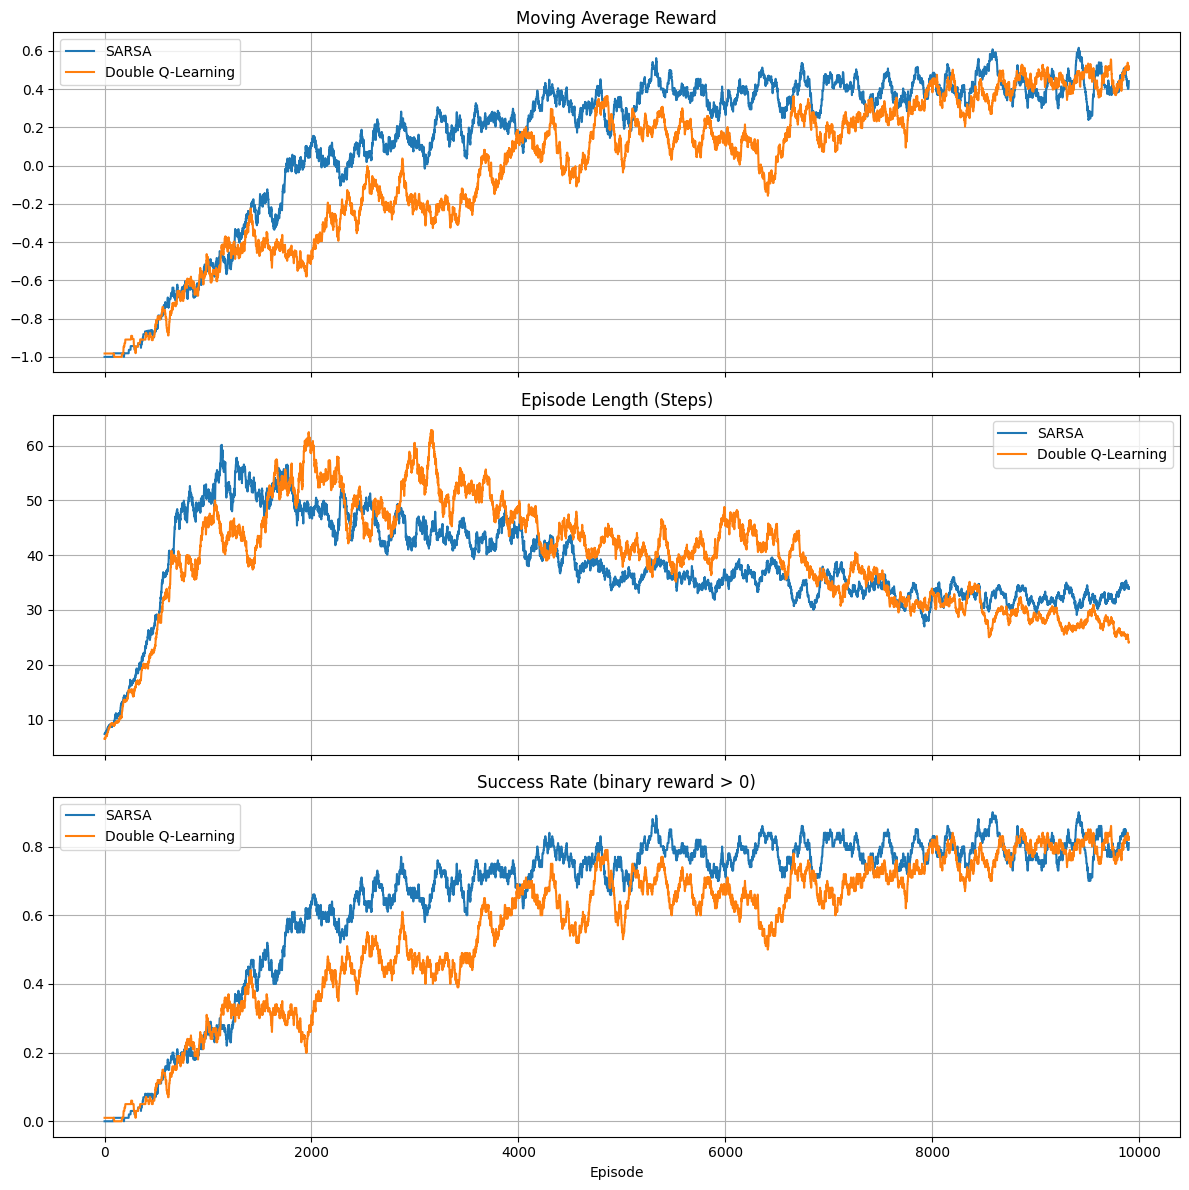

In [38]:
def plot_results(sarsa_logs, dq_logs, window=100):
    def moving_average(data, window):
        return np.convolve(data, np.ones(window)/window, mode='valid')

    fig, axs = plt.subplots(3, 1, figsize=(12, 12), sharex=True)

    axs[0].plot(moving_average(sarsa_logs["rewards"], window), label="SARSA")
    axs[0].plot(moving_average(dq_logs["rewards"], window), label="Double Q-Learning")
    axs[0].set_title("Moving Average Reward")
    axs[0].legend()
    axs[0].grid()

    axs[1].plot(moving_average(sarsa_logs["steps"], window), label="SARSA")
    axs[1].plot(moving_average(dq_logs["steps"], window), label="Double Q-Learning")
    axs[1].set_title("Episode Length (Steps)")
    axs[1].legend()
    axs[1].grid()

    axs[2].plot(moving_average(sarsa_logs["successes"], window), label="SARSA")
    axs[2].plot(moving_average(dq_logs["successes"], window), label="Double Q-Learning")
    axs[2].set_title("Success Rate (binary reward > 0)")
    axs[2].set_xlabel("Episode")
    axs[2].legend()
    axs[2].grid()

    plt.tight_layout()
    plt.show()

plot_results(sarsa_logs, dq_logs)

In [39]:
with open("sarsa_q.pkl", "wb") as f:
    pickle.dump(dict(sarsa_q), f)

with open("dq_q1.pkl", "wb") as f:
    pickle.dump(dict(dq_q1), f)
with open("dq_q2.pkl", "wb") as f:
    pickle.dump(dict(dq_q2), f)